In [1]:
import os
# import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

# matplotlib and seaborn use for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#pandas use for data frame manupulations
import pandas as pd   

from jupyterthemes import jtplot
jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = False) 
# setting the style of the notebook to be monokai theme  
# this line of code is important to ensure that we are able to see the x and y axes clearly
# If you don't run this code line, you will notice that the xlabel and ylabel on any plot is black on black and it will be hard to see them. 


In [2]:
# Specify training data directory
XRay_Directory = 'Chest_X_Ray/train'

In [3]:
# List the folders in the directory
os.listdir(XRay_Directory)

['0', '1', '2', '3']

In [4]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)#normalizations

In [5]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing
train_generator = image_generator.flow_from_directory(batch_size = 40,
                                                    directory = XRay_Directory,
                                                    shuffle = True,
                                                    target_size = (256, 256),#this is our image target size
                                                    class_mode = 'categorical',
                                                    subset = "training"
                                                    )#shuffle mean all the images mix 


Found 428 images belonging to 4 classes.


In [6]:
validation_generator = image_generator.flow_from_directory(batch_size = 40,
                                                           directory = XRay_Directory, 
                                                           shuffle = True, 
                                                           target_size = (256,256), 
                                                           class_mode = 'categorical', 
                                                           subset = "validation")


Found 104 images belonging to 4 classes.


In [7]:
train_images, train_labels = next(train_generator)

In [8]:
train_labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]],

In [9]:
# labels Translator 
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

In [10]:
train_images.shape#40 -batches/256,256 - width and height/3 - RGB

(40, 256, 256, 3)

In [11]:
train_labels.shape#40-batches/4 catogories like 1,0,0,1

(40, 4)

In [12]:
#########Data Visualization#########

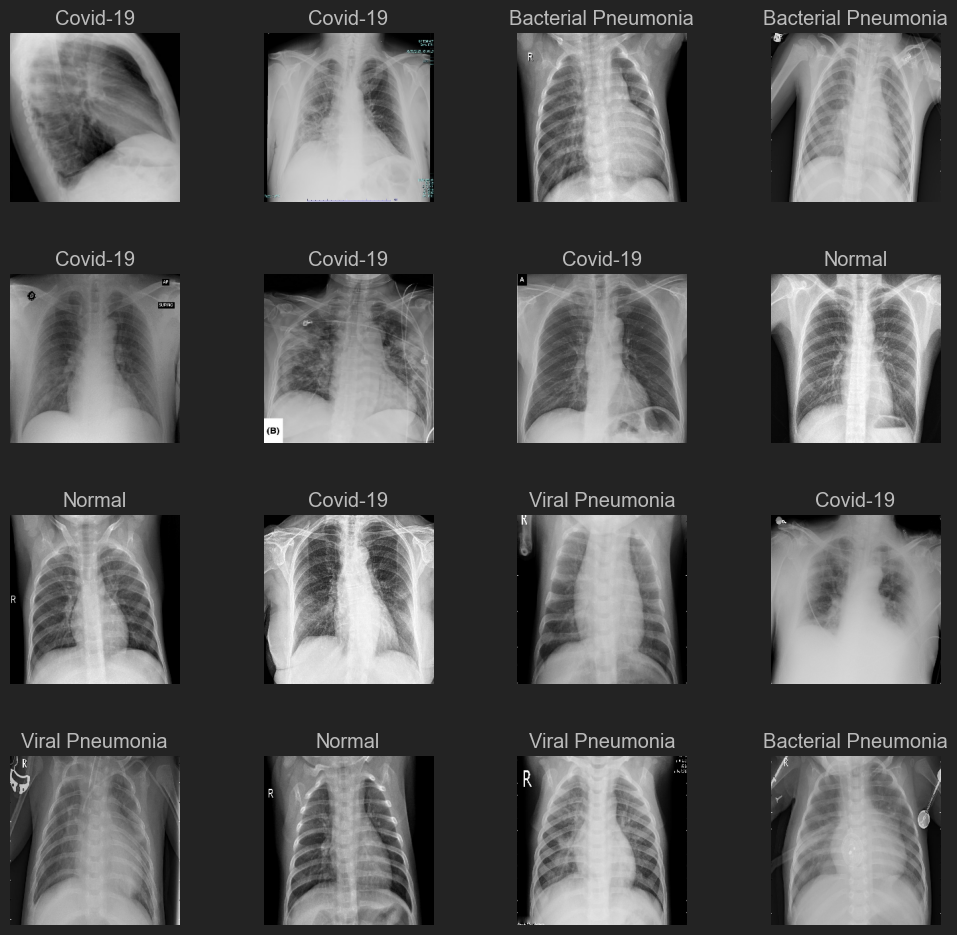

In [13]:
# Create a grid of 16 images along with their corresponding labels
L = 4#actually this mean when we execute this code we can show images in 4 by 4 grid
W = 4

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')
    

plt.subplots_adjust(wspace = 0.5)    

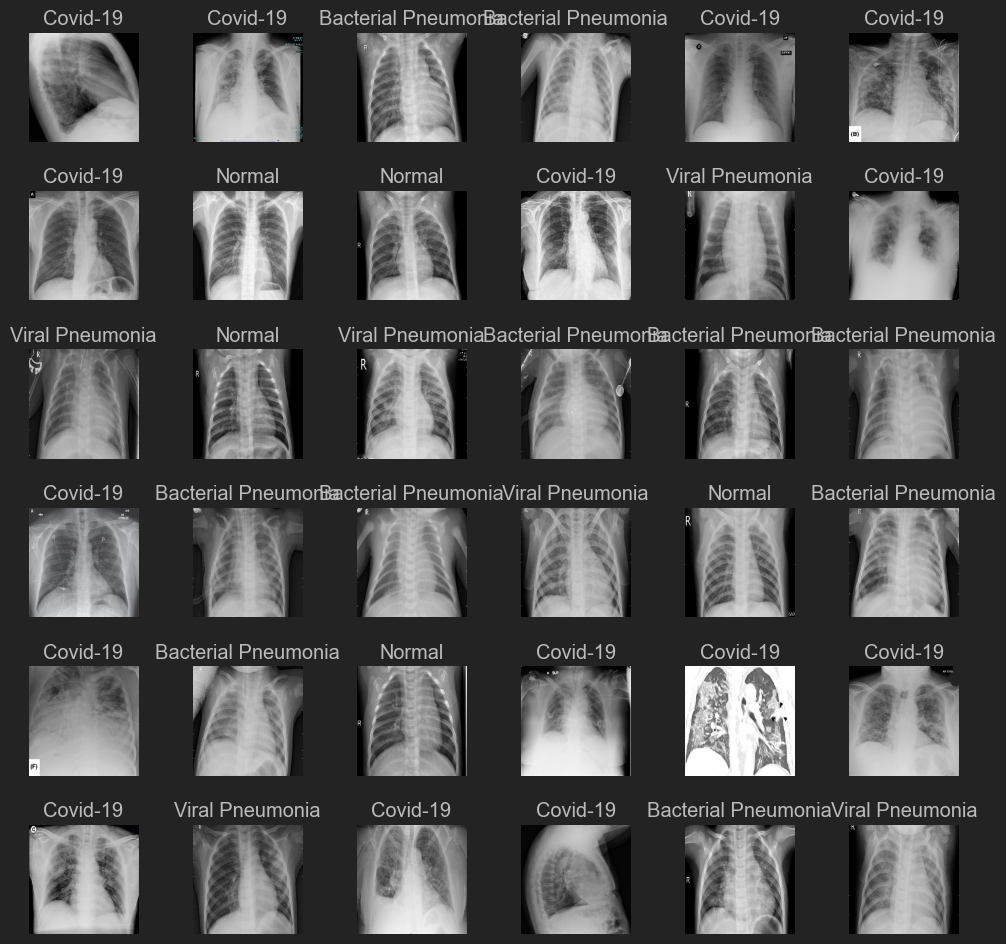

In [14]:
# Create a grid of 16 images along with their corresponding labels
L = 6#actually this mean when we execute this code we can show images in 4 by 4 grid
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')
    

plt.subplots_adjust(wspace = 0.5)    

In [15]:
basemodel = ResNet50(weights = 'imagenet',include_top = False, input_tensor = Input(shape = (256, 256, 3)))

#actually it has an more layers like maxpooling,conv2D and so many layers it has we can see that using below model summary

In [16]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [17]:
#freezing the model upto the last stage - 4 and re-training stage -5 

for layer in basemodel.layers[:-10]:
  layers.trainable = False

In [18]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation ='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)#use for finding generize and not memorize.regularization techniques
headmodel = Dense(128, activation ='relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)


headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [41]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4), metrics= ["accuracy"])

#actually in this case decay mean it can be used for reducing lerning rate over time, but it's not critical thing.that's why if we can use compile function without decay function.

In [42]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [43]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [44]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 1, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

107/107 [==============================] - ETA: 0s - loss: 0.4952 - accuracy: 0.8645
Epoch 1: val_loss improved from inf to 5.96158, saving model to weights.hdf5


C:\Users\THARINDU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 82s 683ms/step - loss: 0.4952 - accuracy: 0.8645 - val_loss: 5.9616 - val_accuracy: 0.2500


In [46]:
#how to load our pre_trained model

In [47]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [48]:
# Let's compile the model 
model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [49]:
test_directory = 'Chest_X_Ray/Test'


In [50]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.


C:\Users\THARINDU\AppData\Local\Temp\ipykernel_17180\3632543790.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)


10/10 [==============================] - 3s 12ms/step - loss: 5.9813 - accuracy: 0.2500
Accuracy Test : 0.25


In [51]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 78ms/step


In [52]:
len(original)

40

In [53]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.25


In [37]:
#testing 5 by 5 grid

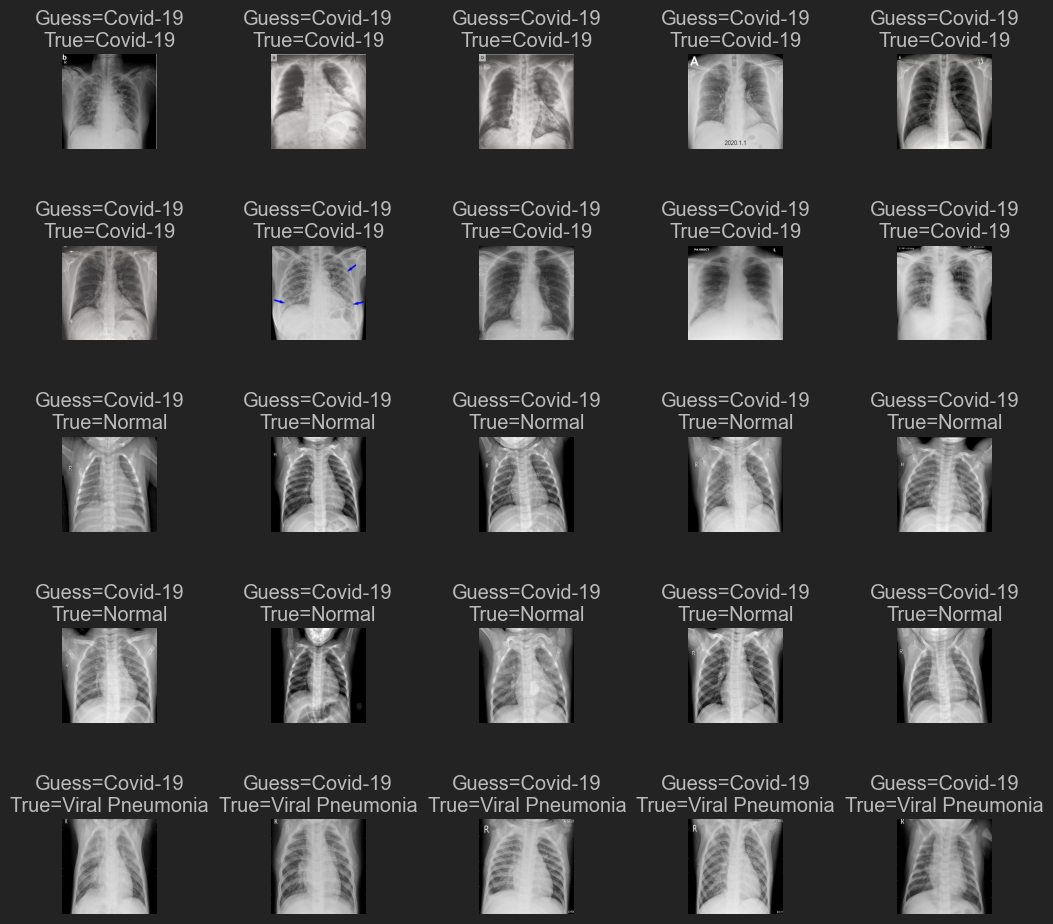

In [38]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [39]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.25      1.00      0.40        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10

    accuracy                           0.25        40
   macro avg       0.06      0.25      0.10        40
weighted avg       0.06      0.25      0.10        40



C:\Users\THARINDU\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\THARINDU\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\THARINDU\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Text(0.5, 1.0, 'Confusion_matrix')

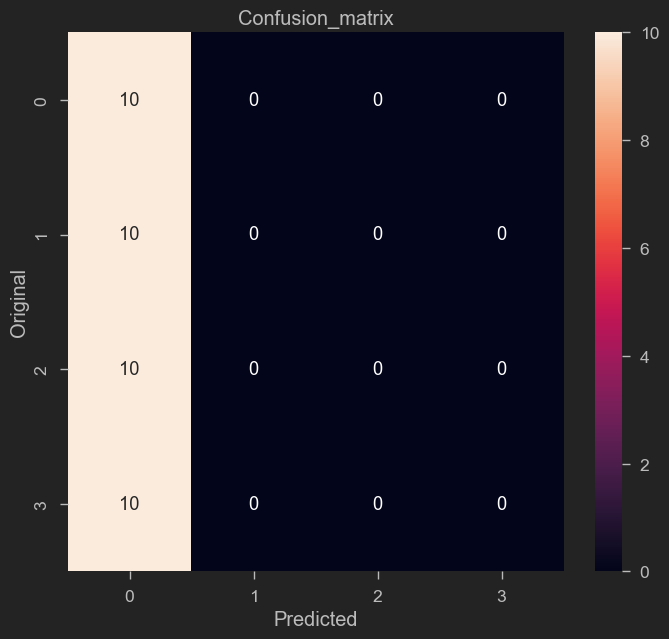

In [40]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))#confution metrix is slimply a visual representation of the model performance
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)#using seaborn visualization

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')